## DestinE Data Streaming

This service offers compressed climate and era5 data and makes it available via a high quality and memory efficient streaming solution. The [SSIM](https://en.wikipedia.org/wiki/Structural_similarity_index_measure) and the mean relative error serve as quality measures.

<div style='white-space: nowrap', align='center'>

<div style='display:inline-block', align='center'>Era5 2 meter dewpoint temperature (01-01-1940 09:00)<br>
<img src="images/2d9_og_.jpeg" width="450px"><br><img src="images/2d9_cp_.jpeg" width="450px"><br>Mean SSIM: 0.996<br>Compression rate 1:13<br>Mean relative error 0.1 %</div>

<div style='display:inline-block', align='center'>Era 5 10 metre U wind component (01-01-1940 09:00)<br>
<img src="images/10u9_og_.jpeg" width="450px"><br><img src="images/10u9_cp_.jpeg" width="450px"><br>Mean SSIM: 0.995<br>Compression rate 1:27<br>Mean relative error 0.3 %</div>

</div>


## Prerequisites
### DestinE Platform Credentials

You need to have an account on the [Destination Earth Platform](https://auth.destine.eu/realms/desp/account).

#### ⚠️ Warning: Authorized Access Only
The usage of this notebook and data access is reserved only to authorized user groups.

## Access the Data
With a DESP account you can access the stream data proposed in this tutorial.

In [1]:
%%capture cap
%run ./auth.py

Type your username:  destinestreamer
Type your password:  ········


In [2]:
output = cap.stdout.split('\n')
#refresh_token = output[1]
token = output[2]

# Imports and general definitions
We start by importing necessary packages and definitions regarding the resolution and the endpoint to the streaming api.

Note: The API token must be set here including the user group. This happens in **Authentification**.

In [3]:
from dtelib2 import DTEStreamer
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython import display

FORMAT = '%Y-%m-%dT%H:%M'

# Parameters for stream access

Here the parameters are set to access the data from the service.

*program_subset*: ERA5 has data from 1940 to 2023 </br>
*variable*: 2t is the 2m temperature</br>
*start_date*: 00:00 of the first day of the month today, fifty years ago</br>
*end_date*: 23:00 of the last day of the month today, fifty years ago</br>
</br>

In [4]:
program_subset = "ERA5"
variable = "2t"

# Finding the first day of this month, 50 years ago
month = datetime.now().month
year = datetime.now().year-50
start_date = f"{year}-{month}-01T00:00"
start_date = datetime.strptime(start_date, FORMAT)

# Finding last day of that month
end_date = f"{year}-{month}-28T23:00"
end_date = datetime.strptime(end_date, FORMAT)
next_month = end_date + timedelta(days=4)
end_date = next_month - timedelta(days=next_month.day)

# Initializing the stream

With the DTEStreamer class we can easily access the data stream through the api and access individual data frames. 

At first, we create a DTEStreamer object with the parameters defined in the step above and the access token. The object initializes by calling the api to get meta information about the stream and the location of the stream. (You can take a look at the api yourself in the swagger [here](https://streamer.destine.eu/api/v1/)). Also, the ffmpeg package is used to seek to the first image according to *start_date*.

In [5]:
streamer = DTEStreamer(program_subset=program_subset,
                       variable=variable,
                       start_date=start_date,
                       end_date=end_date,
                       token=token)


time to seek: 12.34451699256897


# Working with the data

The load_next_image() method loads the first image and its time stamp on its first call, then the second image and so on. With the variable 2t in the program subset ERA5 this means hourly data. Then, the image is sliced into a rectangle that contains the data for Germany: 

![germany_08_08_1940T12_00.png](./images/germany_08_08_1940T12_00.png)

The hardcoded bounds of the image array have been worked out in advance to save time in the loop. It could also be done with other countries/AOIs since the data is georeferenced, with more processing time.

After that, the average of the temperature of Germany is stored in a list. Every 6 hours of data, the stored data is plotted. Plotting takes some time in this example. Feel free to change "plot_every_x_hours" below to any value between 1 and 24. This sets how many hours are loaded before the display is updated again every day.

Set it to 1 to see how granularly the data can be accessed. The loop will run slower, since the time it takes to update the display adds up.

If "plot_every_x_hours" is set to 24, the display is only updated once per day, which makes the progression a lot faster. The same amount of data is loaded and processed either way.

Make sure to run this example from the top if you want to play with this value. (Click on the double play button "Restart the kernel and run all cells")

The vertical gridlines seperate the days at 00:00. On most nights, you can see the temperature falling on midnight.

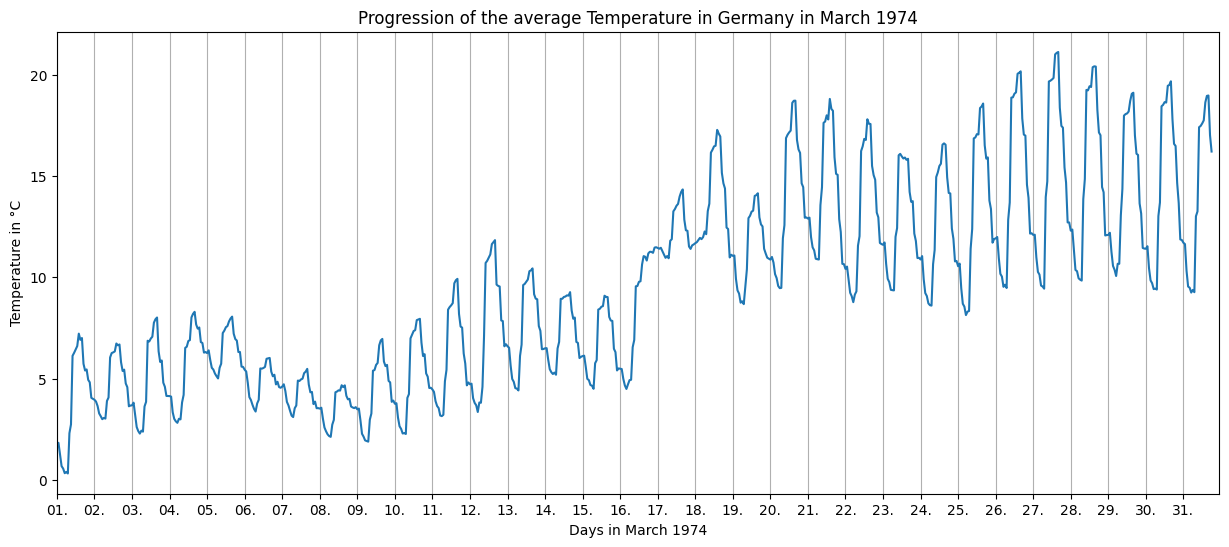

In [6]:
# Change this to values from 1 to 24 to affect in the plotting rate.
# The final plot is the same for any setting.
plot_every_x_hours = 6

# initialize the plot figure
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
hdisplay = display.display('', display_id=True)

ax.set_xlabel(f'Days in {start_date.strftime("%B")} {year}')
ax.set_ylabel(f'Temperature in °C')
plt.title(f'Progression of the average Temperature in Germany in {start_date.strftime("%B")} {year}')

data, t = [], []
ax.plot(data,t)
line = ax.lines[0]
ax.set_xlim(start_date, end_date)

# set ticks and gridlines at the start of each day
ticks = [start_date.replace(day=int(h/24)) for h in range(1, end_date.day*24+1) if h%24==0]
tick_labels = [f'{td.day:02d}.' for td in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.grid(True, axis='x')

for image, time_stamp in streamer.load_next_image():
            
    # isolate German data
    image = image[140:171, 24:60]
    
    # save the average temperature in degree Celsius
    data.append(np.average(image)-273.15)
    t.append(time_stamp)

    # plot 4 times per day to speed up the plot
    if time_stamp.hour%plot_every_x_hours == 0:
        line.set_xdata(t)
        line.set_ydata(data)
        
        # scale plot to fit temperatures
        ax.set_ylim(min(data)-1, max(data)+1)

        hdisplay.update(fig)
        
plt.close(fig)